# Retrieving, Calculating, and Visualizing Perturbed Wind ICON Forecast Data

This notebook demonstrates the full workflow for accessing, calculating, and visualizing perturbed wind forecast data from the ICON numerical weather model. The data is provided by MeteoSwiss as part of Switzerland’s Open Government Data (OGD) initiative.

The core functionality is powered by the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — developed in-house to simplify working with numerical weather model data. It includes the `ogd_api` module for data access, along with utilities for applying temporal and spatial operators to model output, such as calculating wind speed and regridding.

For visualization, this notebook uses the [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html) library developed by ECMWF, which offers intuitive plotting tools for meteorological data.

---

## 🔍 **What You’ll Do in This Notebook**

 🛰️  **Retrieve**  
    Fetch perturbed ICON-CH1-EPS forecast data (e.g., 10m grid eastward and 10m grid northward wind) via the `ogd_api` module.

 📐  **Calculate**  
    Calculate horizontal wind speed using [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/)'s `operator` class.

 🧭  **Regrid**  
    Interpolate ICON data from its native, icosahedral grid to a regular latitude/longitude grid.

 🌍  **Visualize**  
    Plot each ensemble member on a map with meteorological styling using [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html).

---

## Retrieving Precipitation Forecast
In this first part, we retrieve perturbed eastward and northward wind forecast data from the numerical weather model ICON-CH1-EPS. To access this data, we use the `ogd_api` module from the [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/) library — a convenient interface for accessing numerical weather forecasts via the [STAC (SpatioTemporal Asset Catalog) API](https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAsset), which provides structured access to Switzerland’s open geospatial data.

#### 📁  Browsing the STAC Catalog (Optional)

If you'd like to explore the ICON forecast datasets interactively before writing code, you can browse them directly in the STAC catalog:

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH1-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch1?.language=en)

&nbsp;&nbsp;&nbsp;&nbsp;🔗  [Browse the ICON-CH2-EPS collection](https://data.geo.admin.ch/browser/#/collections/ch.meteoschweiz.ogd-forecasting-icon-ch2?.language=en)


Below is a screenshot of the ICON-CH2-EPS collection as seen in the STAC browser interface.


![browser-ch2-resized.PNG](./images/browser-ch2-resized.PNG)

### Creating Requests
To retrieve the forecast data, we first define two API requests using the `ogd_api.Request` class. One for accessing grid eastward wind 10 meter above the surface (`U_10M`) and one for requesting grid northward wind 10 meter above the surface (`V_10M`). Each request targets perturbed data at the initialization time of the forecast.

>⏰ **Forecast Availability**: Forecast data will typically be available a couple of hours after the reference time — due to the model runtime and subsequent upload time. The data remains accessible for 24 hours after upload.

In [20]:
from datetime import datetime, timezone
from meteodatalab import ogd_api

# Set default date of today midnight in UTC
today_midnight_utc = datetime.now(timezone.utc).replace(hour=0, minute=0, second=0, microsecond=0)

# retrieve 10 meter eastward wind
req_U10 = ogd_api.Request(
    collection="ogd-forecasting-icon-ch1",
    variable="U_10M",
    reference_datetime=today_midnight_utc,
    perturbed=True,
    horizon="P0DT0H",
)

# retrieve 10 meter northward wind
req_V10 = ogd_api.Request(
    collection="ogd-forecasting-icon-ch1",
    variable="V_10M",
    reference_datetime=today_midnight_utc,
    perturbed=True,
    horizon="P0DT0H",
)

Each argument in the request serves the following purpose:

| Argument             | Description |
|----------------------|-------------|
| `collection`         | Forecast collection to use (e.g., `ogd-forecasting-icon-ch1`). |
| `variable`           | Meteorological variable of interest (`U_10M` = 10 meter grid eastward wind and `V_10M` = 10 meter grid northward wind). |
| `reference_datetime` | Initialization time of the forecast in **UTC**, provided as either:<br>- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects) object (e.g.,<br> &nbsp; `datetime.datetime(2025, 5, 22, 9, 0, 0, tzinfo=datetime.timezone.utc)`) <br>- [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Combined_date_and_time_representations) date string (e.g., `"2025-05-22T09:00:00Z"`)|
| `perturbed`          | If `True`, retrieves ensemble forecast members; if `False`, returns the deterministic forecast. |
| `horizon`            | Forecast lead time, provided as either:<br>– [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects) object (e.g., `datetime.timedelta(hours=0)`) <br>– [ISO 8601](https://en.wikipedia.org/wiki/ISO_8601#Durations) duration string (e.g., `"P0DT0H"`)|

### Retrieving Data
We now send our requests to the API and retrieve the resulting datasets using the `get_from_ogd()` function.
Each response is returned as an **[xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html)**, which is efficient for handling multi-dimensional data.

> 💡 **Tip**: Use temporary caching with earthkit-data to skip repeated downloads — it's auto-cleaned after the session.
> *For more details, see the [earthkit-data caching docs](https://earthkit-data.readthedocs.io/en/latest/examples/cache.html)*.

> 💡 **Hint**: If you get an error message containing "HTTPError: 403 Client Error: Forbidden for url", you may be trying to retrieve data older than 24h hours! Please adjust your requests.

In [21]:
from earthkit.data import config
config.set("cache-policy", "temporary")

da_U = ogd_api.get_from_ogd(req_U10)
da_V = ogd_api.get_from_ogd(req_V10)

## Data Preprocessing

Once the data has been loaded, continue with the preprocessing of the data if needed. The following preprocessing steps
are described here:
- Calculating horizontal wind speed
- Regridding the data to a regular latitude/longitude grid

### Calculating Wind Speed
To calculate the horizontal wind speed with the `speed` function from [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/), we need the eastward and northward wind [xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) `da_U` and `da_V`.

In [22]:
from meteodatalab.operators import wind

wind_speed = wind.speed(da_U, da_V)
wind_speed

<xarray.DataArray (eps: 10, ref_time: 1, lead_time: 1, z: 1, cell: 1147980)> Size: 46MB
array([[[[[9.4433024e-05, 9.4433024e-05, 9.4433024e-05, ...,
           2.1844261e+00, 2.0442877e+00, 2.2569435e+00]]]],



       [[[[1.9958013e-04, 1.9958013e-04, 1.9958013e-04, ...,
           1.9368479e+00, 1.7868247e+00, 1.7225022e+00]]]],



       [[[[4.0483446e-05, 4.0483446e-05, 4.0483446e-05, ...,
           1.5626141e+00, 1.4871345e+00, 1.4228909e+00]]]],



       ...,



       [[[[2.1485417e-04, 2.1485417e-04, 2.1485417e-04, ...,
           1.6310269e+00, 1.5240237e+00, 1.5574523e+00]]]],



       [[[[1.7378082e-04, 1.7378082e-04, 1.7378082e-04, ...,
           1.8366644e+00, 1.6132191e+00, 1.6036783e+00]]]],



       [[[[1.9996484e-04, 1.9996484e-04, 1.9996484e-04, ...,
           1.9665487e+00, 1.9155438e+00, 1.8497195e+00]]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 80B 1 2 3 4 5 6 7 8 9 10
  * ref_time    (ref_time) datetime64[ns] 8B 2025-05-08
  * lead_time   (lead_time) timedelta64[ns] 8B 00:00:00
  * z           (z) int64 8B 10
    lon         (cell) float32 5MB 17.71 17.69 17.7 17.7 ... 12.81 12.81 12.8
    lat         (cell) float32 5MB 50.24 50.24 50.24 50.23 ... 50.06 50.05 50.04
    valid_time  (ref_time, lead_time) datetime64[ns] 8B 2025-05-08
Dimensions without coordinates: cell
Attributes:
    metadata:     <earthkit.data.core.metadata.WrappedMetadata object at 0x7e...
    parameter:    {'centre': 'lssw', 'paramId': 500025, 'shortName': 'SP_10M'...
    geography:    {'gridType': 'unstructured_grid', 'bitmapPresent': 0}
    vref:         geo
    vcoord_type:  heightAboveGround
    origin_z:     0.0

The resulting `xarray.DataArray` has the following dimensions:

- `eps` (ensemble members): 10 members (for ICON-CH1-EPS data)
- `ref_time`: Single reference time (e.g. default date of today midnight)
- `lead_time`: Single lead time (e.g +0 hours)
- `cell`: 1,147,980 spatial grid points

It includes attributes specifying some meta data such as:

- `parameter`: information on the meteorogical parameter, here wind speed
- `vcoord_type`: information of the vertical coordinate type, here heightAboveGround

> &#x1F525; **Expert users:** If you are interested in detailed meta data information, i.e. the GRIB encodings, you can retrieve it from the `metadata` attribute.
Please refer to the [earthkit-data metadata documentation](https://earthkit-data.readthedocs.io/en/latest/examples/metadata.html).

### Regridding to a Regular Grid
To enable visualization or comparison with other geospatial datasets, you may want to regrid the ICON data from its native, unstructured grid onto a regular latitude/longitude grid. This can be done using the `regrid` utilities provided by [meteodata-lab](https://meteoswiss.github.io/meteodata-lab/).

Below, we define the target grid using a bounding box over the area of interest, specify the output resolution, and apply the remapping on each of the 10 ensemble members.


In [27]:
from meteodatalab.operators.regrid import CRS, iconremap, RegularGrid

# Define the target grid extent and resolution
xmin=2439000
xmax=2867000
ymin=1040500
ymax=1334500
nx, ny = 215, 148             # Number of grid points in x and y

# Create a regular lat/lon grid using EPSG:2056
destination = RegularGrid(
    CRS.from_string("epsg:2056"), nx, ny, xmin, xmax, ymin, ymax
)

# Remap ICON native grid data to the regular grid for each ensemble member
wind_geo_list = []
num_of_eps = len(wind_speed.eps)

for i in range(num_of_eps):
    wind_geo = iconremap(wind_speed.isel(eps=i), destination)
    wind_geo_list.append(wind_geo)

## Visualizing Wind Speed
We now visualize the predicted wind speeds for each of the ensemble members on a map. This uses [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/01-introduction.html), the visualization component of [Earthkit](https://earthkit.readthedocs.io/en/latest/) — a suite of tools designed to simplify access, processing, and visualization of weather and climate data in Python.

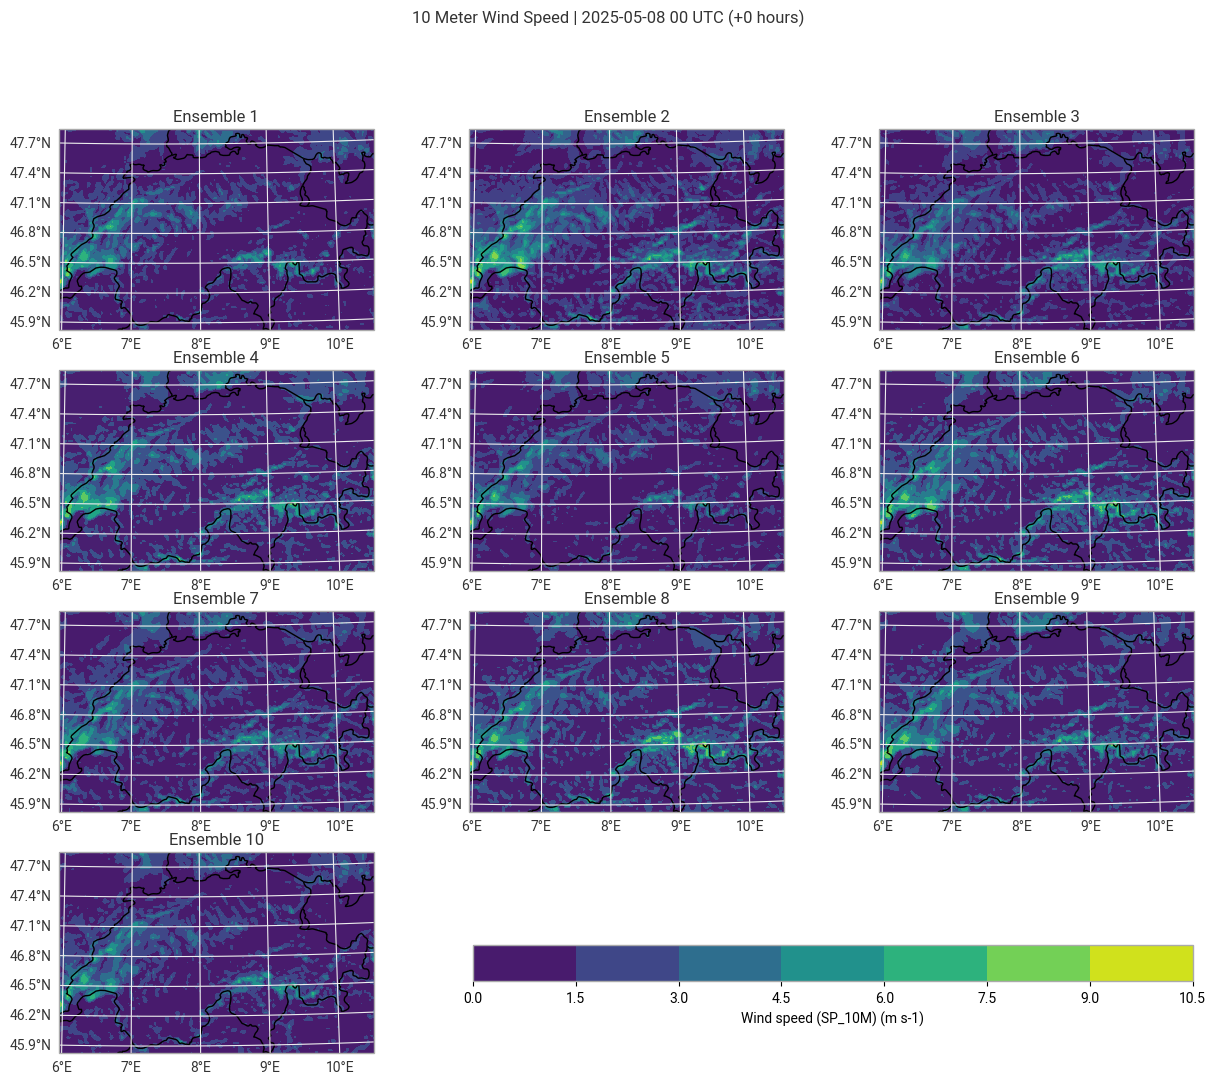

In [ ]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import pandas as pd
import matplotlib.pyplot as plt

# Define the Coordinate Reference System (CRS)
crs = ccrs.epsg(2056)

# Create the figure instance
figure = plt.figure(figsize=(10,8))

# Plot the regridded wind speed for each subplot
for idx, wind_geo in enumerate(wind_geo_list):

    # Create a subplot
    ax = figure.add_subplot(4, 3, idx + 1, projection=crs)

    # Remove unnecessary dimensions
    f = wind_geo.squeeze()

    # Plot wind speed
    c = ax.contourf(destination.x, destination.y, f.values, transform=crs)

    # Set subplot title
    eps = wind_geo.coords["eps"].values

    # Add features
    ax.set_title(f"Ensemble {eps}")
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(draw_labels=True)

    # Ignore redundant lables
    gl.top_labels = False
    gl.right_labels = False

# Prepare colorbar title and specify location
wind_param = wind_geo_list[0].attrs["parameter"]
legend_label = f"{wind_param['name']} ({wind_param['units']})"
cax = plt.axes((0.41, 0.17, 0.48, 0.03))

# Prepare figure title
ref_time = pd.to_datetime(wind_geo_list[0].coords["ref_time"].values[0]).strftime("%Y-%m-%d %H UTC")
lead_time = wind_geo_list[0].coords["lead_time"].values[0].astype('timedelta64[h]')
title = f"10 Meter Wind Speed | {ref_time} (+{lead_time})"

# Add figure title and colorbar
figure.suptitle(title)
figure.colorbar(c, cax=cax, orientation='horizontal', label=legend_label)
